In [1]:
cd ~/yoloassignment

/root/yoloassignment


In [2]:
%matplotlib inline
#import autoreload
%load_ext autoreload
%autoreload

In [3]:
import config
import torch
import torch.optim as optim

from model import YOLOv3
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from loss import YoloLoss
import warnings
warnings.filterwarnings("ignore")

In [4]:
import torch
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import pandas as pd
from torch.optim.lr_scheduler import OneCycleLR

In [5]:
import seaborn as sn

In [6]:
class Assignment13(LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self.epoch_number = 0
        self.config = config
        self.train_csv_path = self.config.DATASET + "/train.csv"
        self.test_csv_path = self.config.DATASET + "/test.csv"
        self.train_loader, self.test_loader, self.train_eval_loader = get_loaders(
              train_csv_path=self.train_csv_path, test_csv_path=self.test_csv_path)
        self.check_class_accuracy = check_class_accuracy
        self.model = YOLOv3(num_classes=self.config.NUM_CLASSES)
        self.loss_fn = YoloLoss()
        self.check_class_accuracy = check_class_accuracy
        self.get_evaluation_bboxes = get_evaluation_bboxes
        self.scaled_anchors = (torch.tensor(self.config.ANCHORS) * torch.tensor(self.config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))
        self.losses = []
        self.plot_couple_examples = plot_couple_examples
        self.mean_average_precision = mean_average_precision
        self.EPOCHS = self.config.NUM_EPOCHS * 2 // 5
    def forward(self, x):
        out = self.model(x)
        return out
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        y0, y1, y2 = (y[0],y[1],y[2])
        loss = (
                self.loss_fn(out[0], y0, self.scaled_anchors[0].to(y0))
                + self.loss_fn(out[1], y1, self.scaled_anchors[1].to(y1))
                + self.loss_fn(out[2], y2, self.scaled_anchors[2].to(y2))
            )
        self.losses.append(loss.item())
        mean_loss = sum(self.losses) / len(self.losses)
        self.log("train_loss", mean_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #self.log("train_loss", mean_loss)
        return loss


    def on_train_epoch_start(self):
        self.epoch_number += 1
        self.losses = []
        #self.plot_couple_examples(self.model,self.test_loader,0.6,0.5,self.scaled_anchors)
        if self.epoch_number > 1 and self.epoch_number % 10 == 0:
            self.plot_couple_examples(self.model,self.test_loader,0.6,0.5,self.scaled_anchors)

    def on_train_epoch_end(self):
        print(f"Currently epoch {self.epoch_number}")
        print("On Train Eval loader:")
        print("On Train loader:")
        self.check_class_accuracy(self.model, self.train_loader, threshold=self.config.CONF_THRESHOLD)
        if self.epoch_number == self.EPOCHS:
              #if self.epoch_number > 1 and self.epoch_number % 3 == 0:
            self.check_class_accuracy(self.model, self.test_loader, threshold=self.config.CONF_THRESHOLD)
            pred_boxes, true_boxes = self.get_evaluation_bboxes( self.test_loader,self.model,iou_threshold=self.config.NMS_IOU_THRESH,
                                                                 anchors=self.config.ANCHORS,
                                                                 threshold=self.config.CONF_THRESHOLD,)
            mapval = self.mean_average_precision(
                pred_boxes,
                true_boxes,
                iou_threshold=self.config.MAP_IOU_THRESH,
                box_format="midpoint",
                num_classes=self.config.NUM_CLASSES,
            )
            print(f"MAP: {mapval.item()}")
            self.model.train()
            pass


    def configure_optimizers(self,override_lr=1E-3):
        optimizer = optimizer = optim.Adam(
                    model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
        #EPOCHS = config.NUM_EPOCHS * 2 // 5
        scheduler = OneCycleLR(
        optimizer,
        max_lr=override_lr,
        steps_per_epoch=len(self.train_loader),
        epochs=self.EPOCHS,
        pct_start=5/self.EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
        )

        return {"optimizer": optimizer, "lr_scheduler":scheduler}
        
     ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
          return self.train_loader

    def test_dataloader(self):
          return self.test_loader

    

In [7]:
#finding maximum learning rate
model = Assignment13()
trainer = Trainer(precision=16,accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=0)])

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model,max_lr=2, num_training=180,mode="exponential")

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/yoloassignment/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/180 [00:00<?, ?it/s]

Currently epoch 1
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:36<00:00,  5.37it/s]
`Trainer.fit` stopped: `max_steps=157` reached.
LR finder stopped early after 157 steps due to diverging loss.
Restoring states from the checkpoint path at /root/yoloassignment/.lr_find_f1b91ee9-1ca2-446a-9b41-f43402b66064.ckpt


Class accuracy is: 12.155572%
No obj accuracy is: 99.522362%
Obj accuracy is: 0.014014%


Restored all states from the checkpoint file at /root/yoloassignment/.lr_find_f1b91ee9-1ca2-446a-9b41-f43402b66064.ckpt


0.0024869639913396094


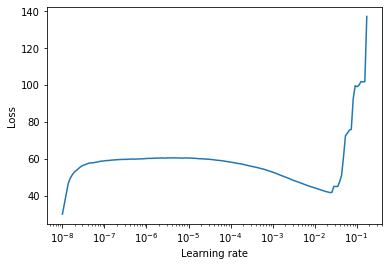

In [8]:
# Inspect results
fig = lr_finder.plot(); fig.show()
suggested_lr = lr_finder.suggestion()
print(suggested_lr)
# Overwrite lr and create new model
#hparams.lr = suggested_lr
#model = MyModelClass(hparams)


In [8]:
0.19340142196244856

0.19340142196244856

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | YOLOv3   | 61.6 M
1 | loss_fn | YoloLoss | 0     
-------------------------------------
61.6 M    Trainable params
0         Non-trainable params
61.6 M    Total params
123.253   Total estimated model params size (MB)


Currently epoch 1
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.43it/s]


Class accuracy is: 32.226460%
No obj accuracy is: 3.133717%
Obj accuracy is: 92.094986%
Currently epoch 2
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.43it/s]


Class accuracy is: 33.731434%
No obj accuracy is: 16.376640%
Obj accuracy is: 72.224770%
Currently epoch 3
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.40it/s]


Class accuracy is: 35.320480%
No obj accuracy is: 56.519539%
Obj accuracy is: 62.078297%
Currently epoch 4
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.44it/s]


Class accuracy is: 36.820705%
No obj accuracy is: 85.763969%
Obj accuracy is: 58.589989%
Currently epoch 5
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.42it/s]


Class accuracy is: 37.843029%
No obj accuracy is: 88.910904%
Obj accuracy is: 63.170944%
Currently epoch 6
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.42it/s]


Class accuracy is: 39.462368%
No obj accuracy is: 93.394547%
Obj accuracy is: 54.506367%
Currently epoch 7
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.41it/s]


Class accuracy is: 42.340408%
No obj accuracy is: 93.120949%
Obj accuracy is: 60.934223%
Currently epoch 8
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.42it/s]


Class accuracy is: 45.508400%
No obj accuracy is: 93.217087%
Obj accuracy is: 62.533615%
Currently epoch 9
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.43it/s]

Class accuracy is: 47.247223%
No obj accuracy is: 93.477097%
Obj accuracy is: 64.715141%


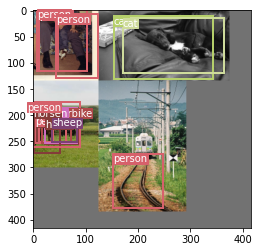

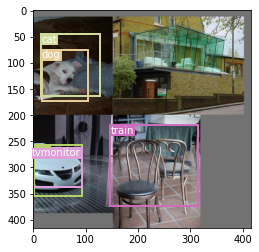

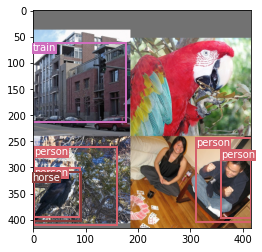

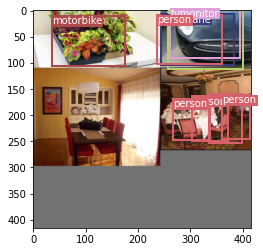

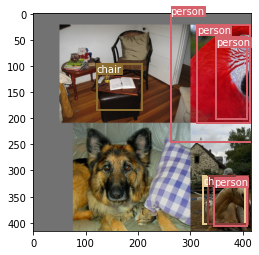

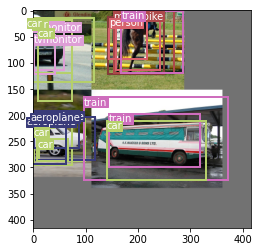

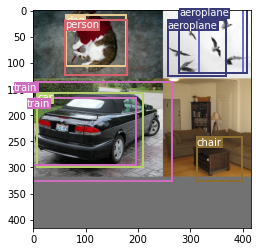

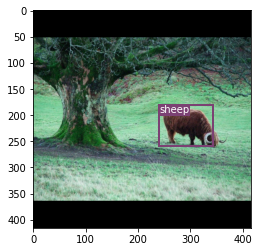

Currently epoch 10
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.43it/s]


Class accuracy is: 48.469425%
No obj accuracy is: 93.216843%
Obj accuracy is: 68.956932%
Currently epoch 11
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.42it/s]


Class accuracy is: 50.622986%
No obj accuracy is: 93.367195%
Obj accuracy is: 67.367401%
Currently epoch 12
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:36<00:00,  5.37it/s]


Class accuracy is: 53.491966%
No obj accuracy is: 93.809471%
Obj accuracy is: 70.420105%
Currently epoch 13
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.42it/s]


Class accuracy is: 54.248417%
No obj accuracy is: 94.004044%
Obj accuracy is: 72.683624%
Currently epoch 14
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.42it/s]


Class accuracy is: 55.281811%
No obj accuracy is: 95.283379%
Obj accuracy is: 68.015533%
Currently epoch 15
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.40it/s]


Class accuracy is: 57.351704%
No obj accuracy is: 94.176521%
Obj accuracy is: 73.201080%
Currently epoch 16
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.42it/s]


Class accuracy is: 59.543270%
No obj accuracy is: 94.841354%
Obj accuracy is: 71.955780%
Currently epoch 17
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:36<00:00,  5.39it/s]


Class accuracy is: 58.490055%
No obj accuracy is: 95.097015%
Obj accuracy is: 72.447342%
Currently epoch 18
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.40it/s]


Class accuracy is: 60.799576%
No obj accuracy is: 94.859383%
Obj accuracy is: 74.761108%
Currently epoch 19
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.41it/s]

Class accuracy is: 61.636044%
No obj accuracy is: 94.851723%
Obj accuracy is: 76.143333%


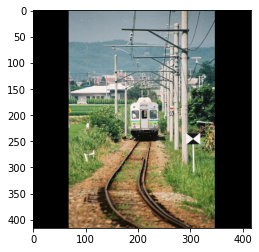

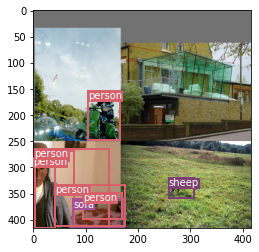

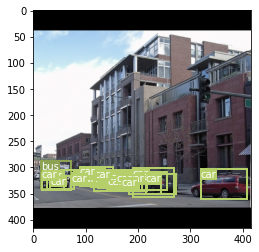

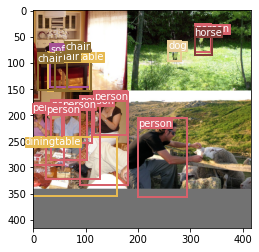

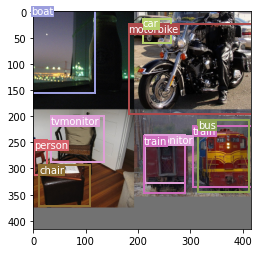

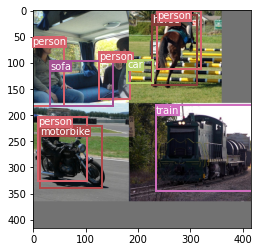

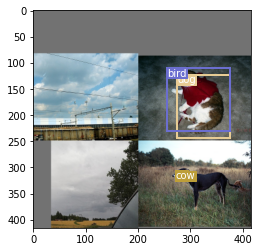

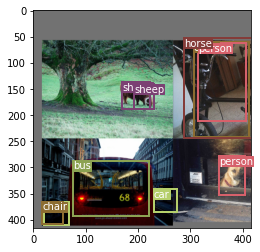

Currently epoch 20
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.42it/s]


Class accuracy is: 60.257286%
No obj accuracy is: 95.326637%
Obj accuracy is: 75.074387%
Currently epoch 21
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:36<00:00,  5.39it/s]


Class accuracy is: 64.249275%
No obj accuracy is: 94.939301%
Obj accuracy is: 77.564926%
Currently epoch 22
On Train Eval loader:
On Train loader:


 23%|██▎       | 118/518 [00:23<01:12,  5.52it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Currently epoch 39
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.42it/s]

Class accuracy is: 76.465019%
No obj accuracy is: 96.471695%
Obj accuracy is: 79.380974%


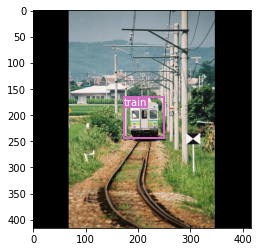

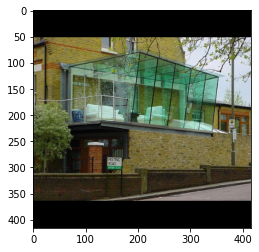

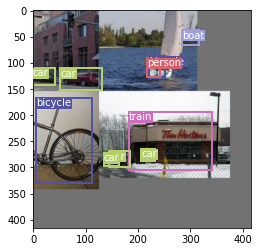

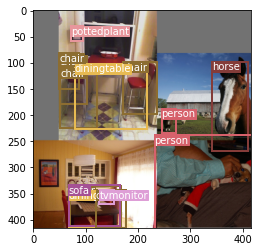

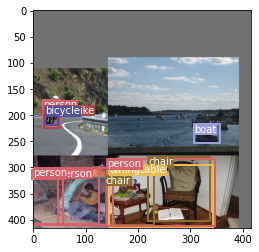

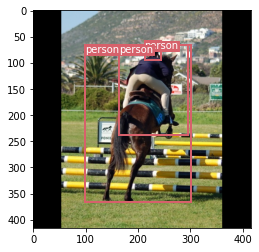

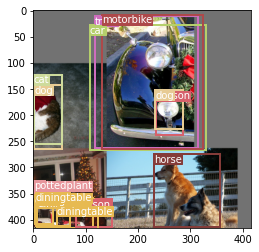

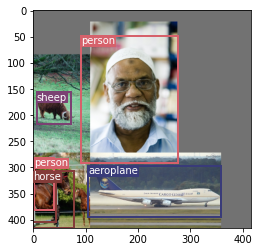

Currently epoch 40
On Train Eval loader:
On Train loader:


100%|██████████| 518/518 [01:35<00:00,  5.41it/s]


Class accuracy is: 76.721313%
No obj accuracy is: 96.630630%
Obj accuracy is: 79.087128%


100%|██████████| 155/155 [00:29<00:00,  5.32it/s]


Class accuracy is: 74.341980%
No obj accuracy is: 96.547806%
Obj accuracy is: 76.078262%


100%|██████████| 155/155 [26:43<00:00, 10.35s/it]


In [ ]:
model = Assignment13()
model.configure_optimizers(override_lr=suggested_lr)
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',  # Metric to monitor for saving the best model
    mode='min', # 'min' to save the model with the lowest value of the monitored metric
    dirpath='/storage/',
    filename='assignment13_final{epoch:02d}-train_loss_min_A400_1_10_2_3{train_loss:.2f}',
    save_top_k=1         # Save only the best model
)

trainer = Trainer(
    max_epochs=config.NUM_EPOCHS * 2 // 5,
    accelerator="gpu",
    precision=16,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"),TQDMProgressBar(refresh_rate=0),checkpoint_callback],
)


trainer.fit(model)

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")
